Basic Tree analysis
===================

The objective of this notebook is to learn how to perform tree inference from single cell data, starting from a count matrix. Features that significantly changes along the tree will then be extracted and clustered.

## Importing modules and basic settings

In [1]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import palantir
import scanpy as sc
import scFates as scf

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [2]:
import sys
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

## Run pipeline from Palantir

This cell follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) with some slight changes. Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

### Load, normalize and log-transform count data

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df = sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)

### Perform PCA on highly variable genes

In [4]:
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


### Run Palantir to obtain multiscale diffusion space

In [5]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


### Generate embedding from the multiscale diffusion space

In [6]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [7]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:23)


### Plotting results

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


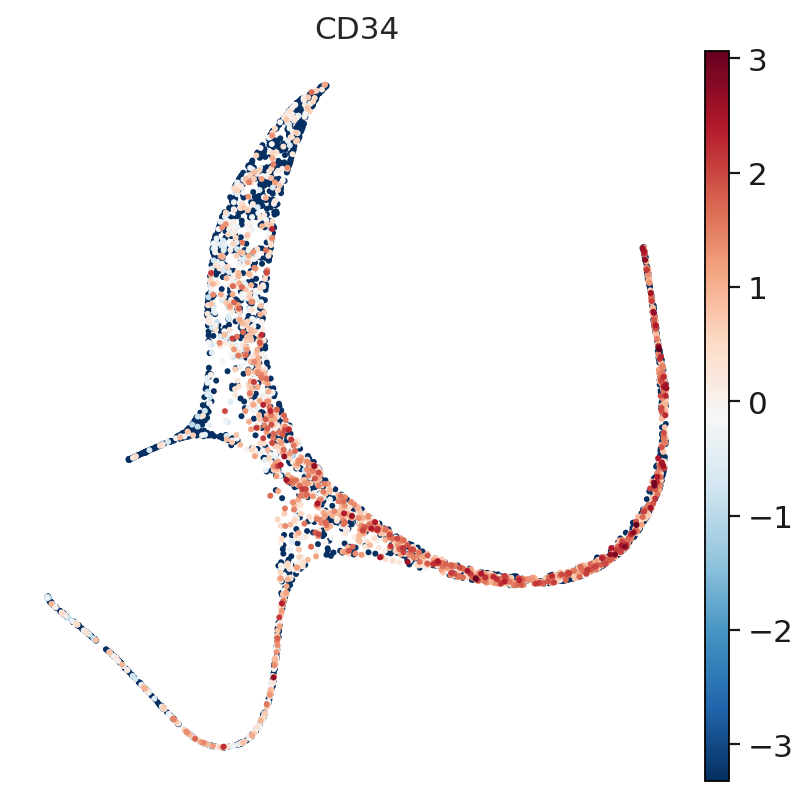

In [8]:
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6))
sc.pl.draw_graph(adata,color="CD34",color_map="RdBu_r")

## Learn tree using ElPiGraph algorithm

We will infer a principal tree on the multiscale diffusion space generated by Palantir. Any dimensionality reduction in `.obsm` can be selected using `use_rep` parameter. The method for tree learning is defined by `method` parameter: Here we choose ElPiGraph ('epg').  

In [9]:
scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="cpu",seed=1,epg_lambda= .05)

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.05
    finished (0:00:18) --> added 
    .uns['epg'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


## Projecting the tree on the tsne computed from Palantir

By default the plot function will annotate automatically the tips and the forks ids.

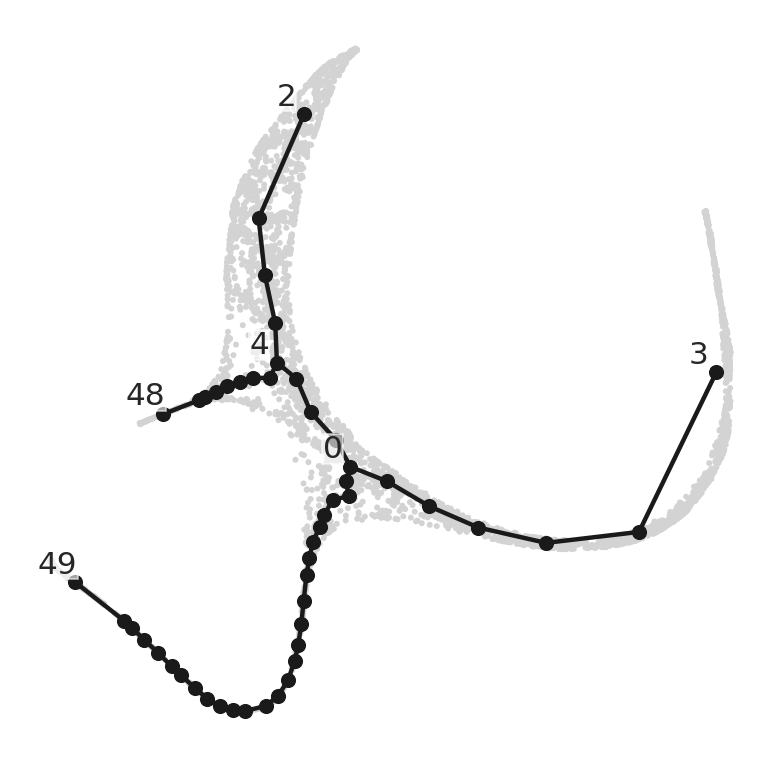

In [10]:
scf.pl.graph(adata,basis="draw_graph_fa")

## Selecting a root and computing pseudotime

Using CD34 marker, we can confidently tell that the tip 3 is the root.

In [11]:
scf.tl.root(adata,3)

node 3 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Having the root selected, we can now project the cells onto the tree and compute the pseudotime value for each of them.

In [12]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


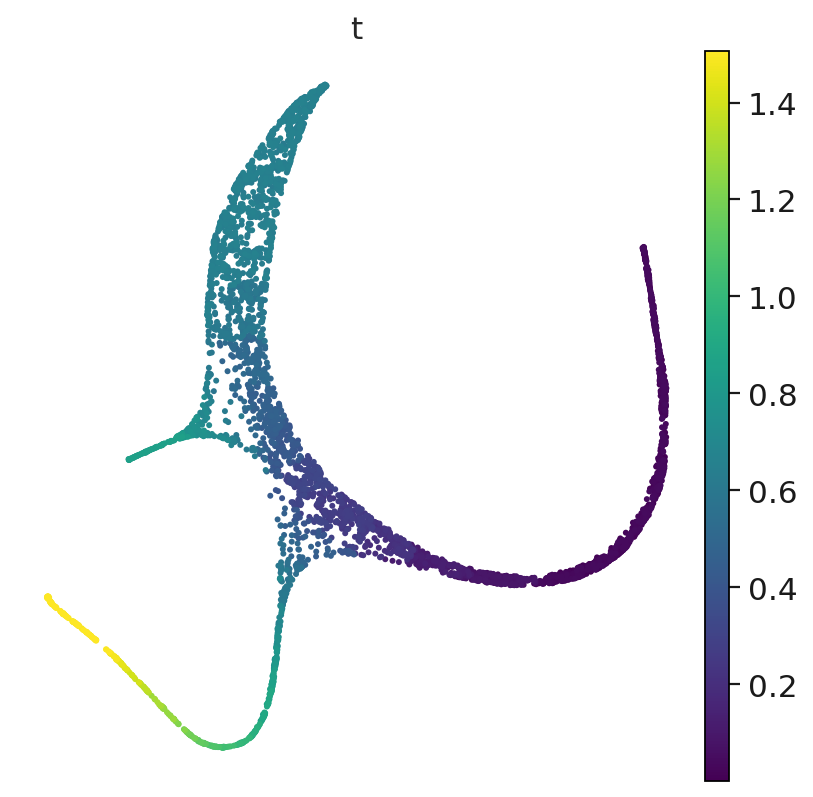

In [13]:
sc.pl.draw_graph(adata,color="t",cmap="viridis")

## Representing the trajectory and tree

### On top of existing embedding

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


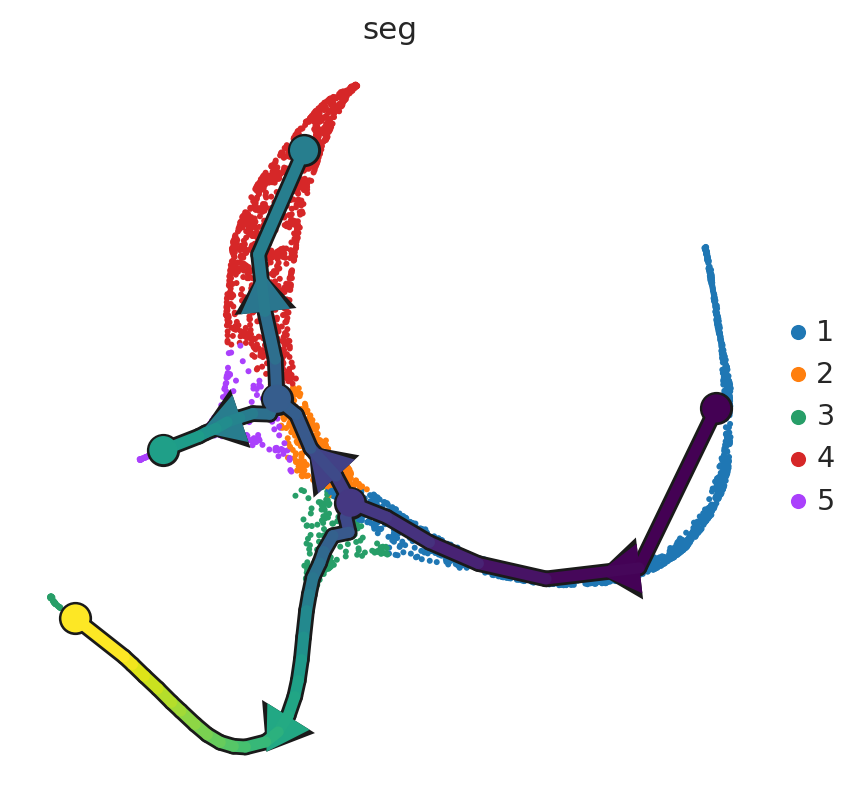

In [14]:
scf.pl.trajectory(adata,basis="draw_graph_fa",
                  color_cells="seg",arrows=True,arrow_offset=1)

### By generating dendrogram single cell representation

In [15]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    finished (0:00:06) --> added 
    .obs['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


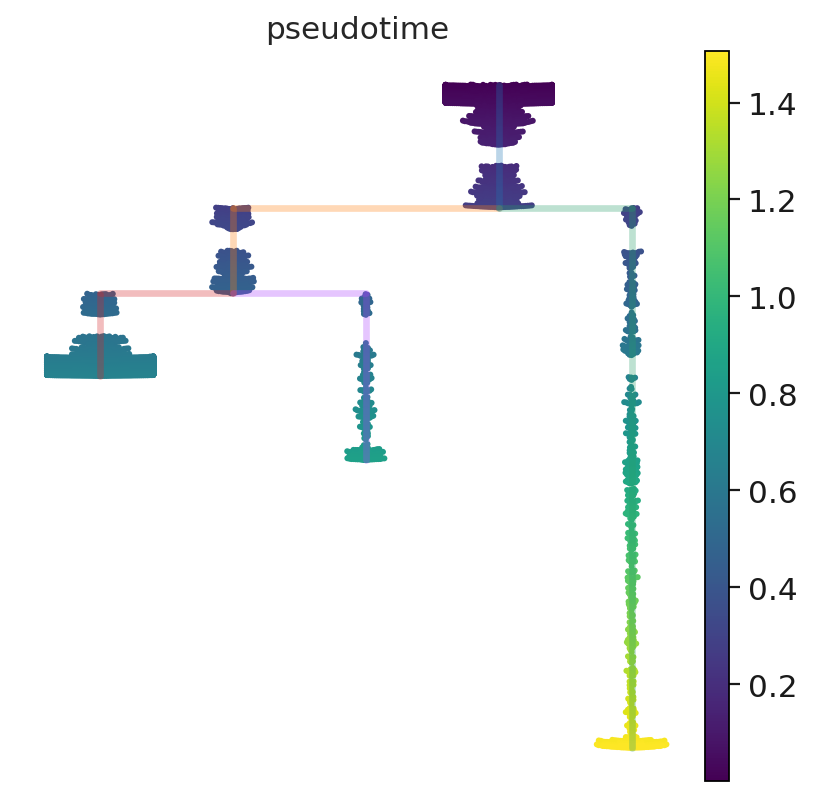

In [16]:
scf.pl.dendrogram(adata,color_seg="seg",color="t",cmap="viridis",title="pseudotime")

## Test and fit associated features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [17]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 16106/16106 [03:07<00:00, 85.90it/s]
    found 3121 significant features (0:03:07) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


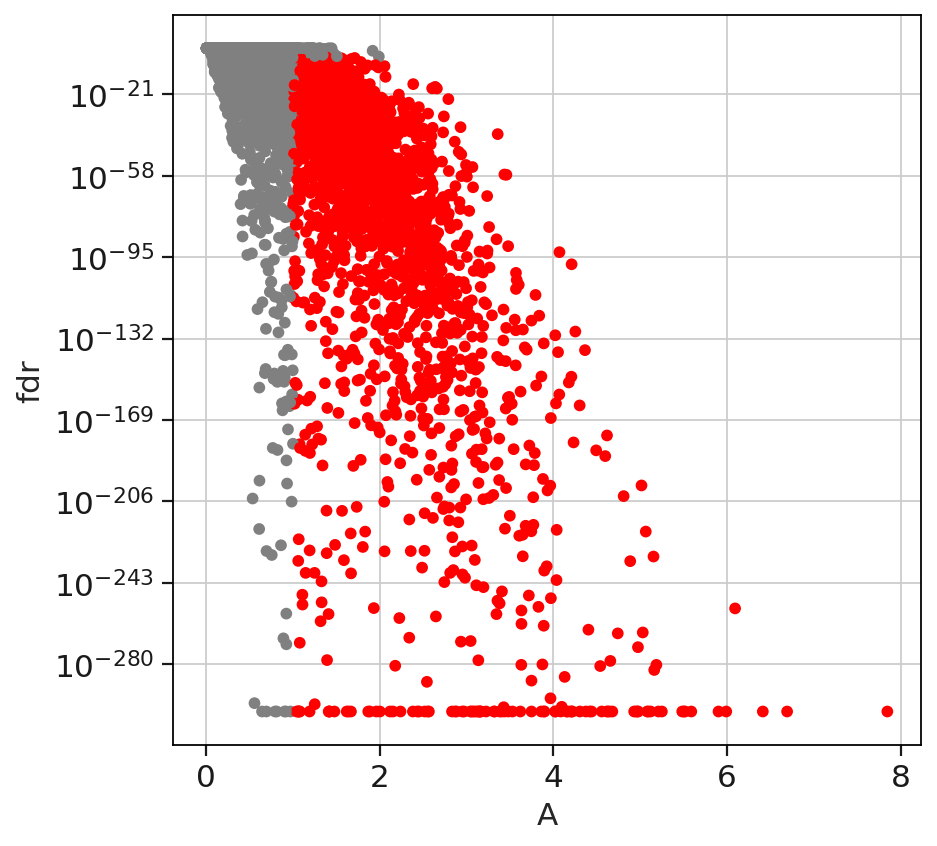

In [18]:
scf.pl.test_association(adata)

We can now fit the significant genes.

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw)

</div>

In [19]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 3121/3121 [01:41<00:00, 30.64it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:48) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


## Plot single features

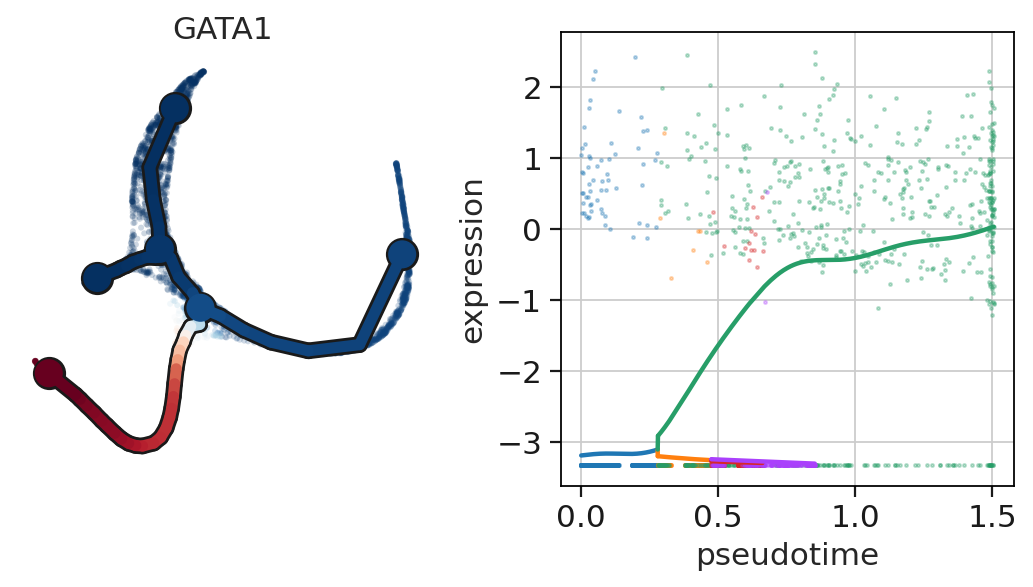

In [20]:
scf.pl.single_trend(adata,feature="GATA1",basis="draw_graph_fa",alpha=.2)

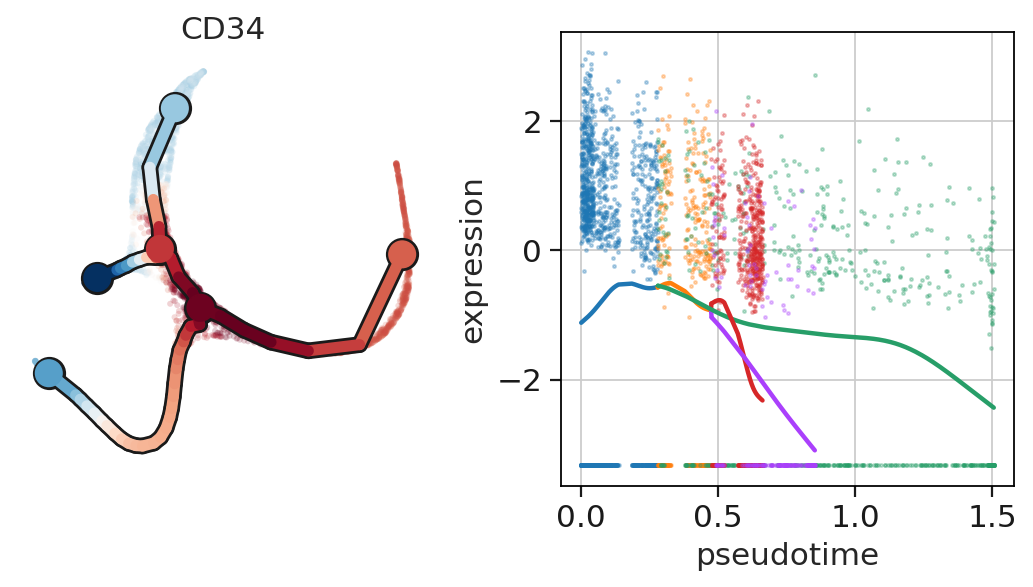

In [21]:
scf.pl.single_trend(adata,feature="CD34",basis="draw_graph_fa",alpha=.2)

## Cluster and plot fitted features

In [22]:
scf.tl.cluster(adata,knn=300,metric="correlation",device="cpu")

    clustering using phenograph
Finding 300 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 13.323155403137207 seconds
Jaccard graph constructed in 74.2506263256073 seconds
Wrote graph to binary file in 4.571375846862793 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.600007
After 2 runs, maximum modularity is Q = 0.603175
Louvain completed 22 runs in 7.458582162857056 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 104.44151973724365 seconds
    finished (0:02:05) --> added
    .var['fit_clusters'], cluster assignments for features.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


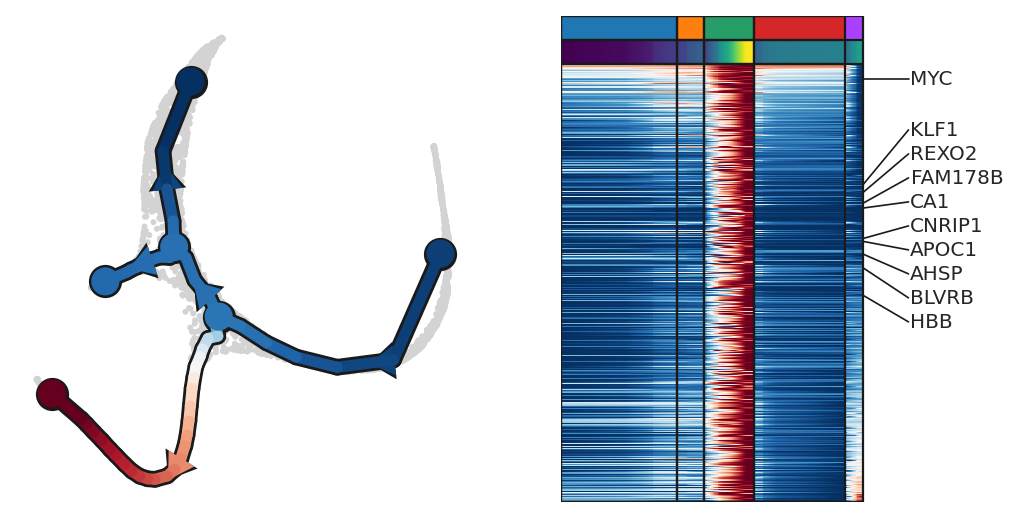

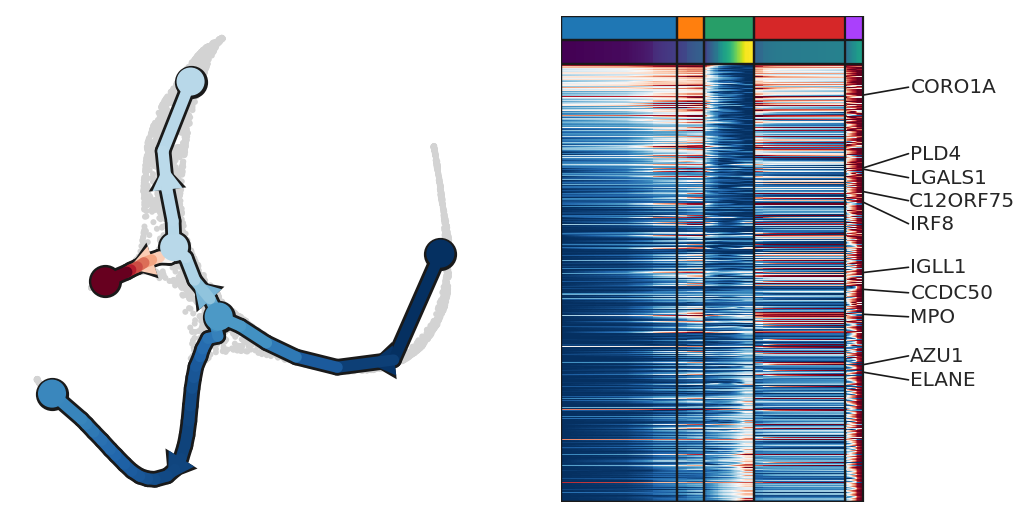

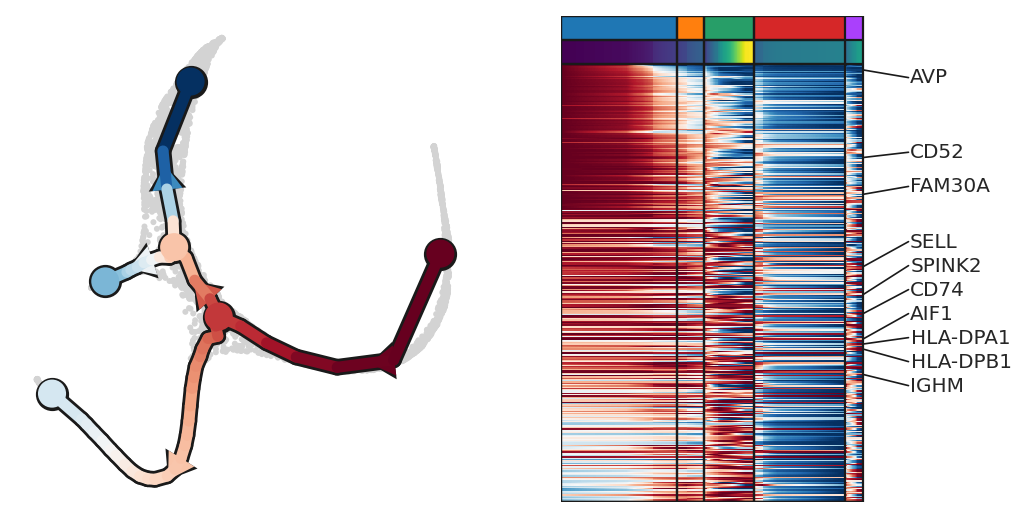

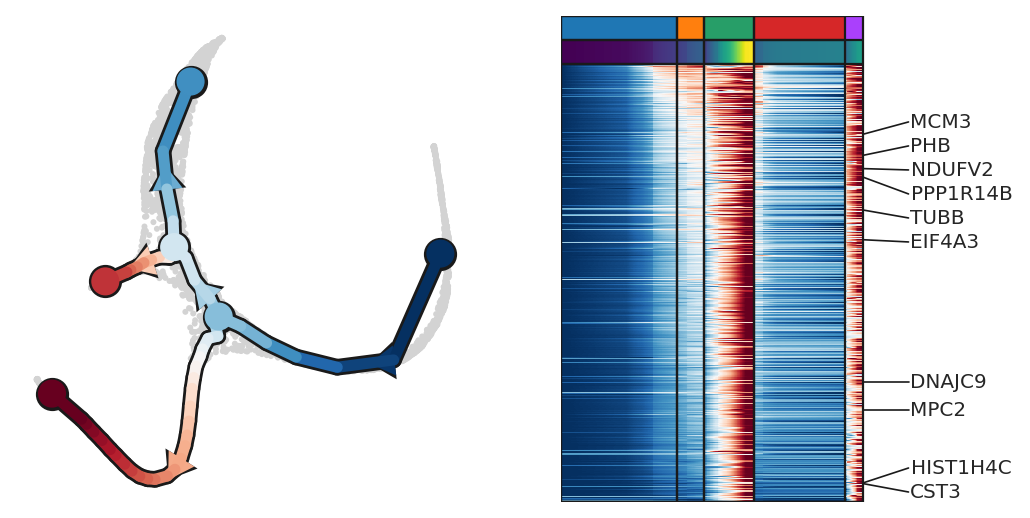

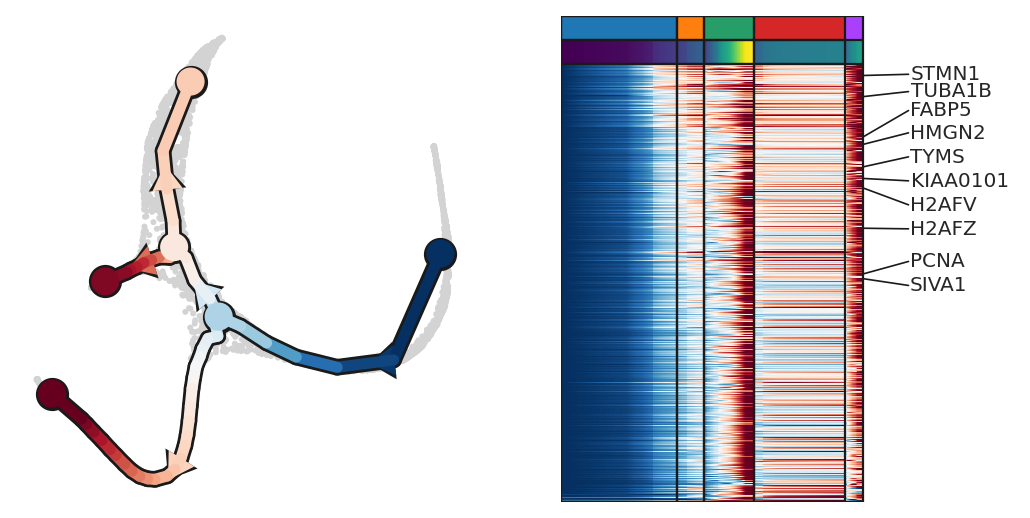

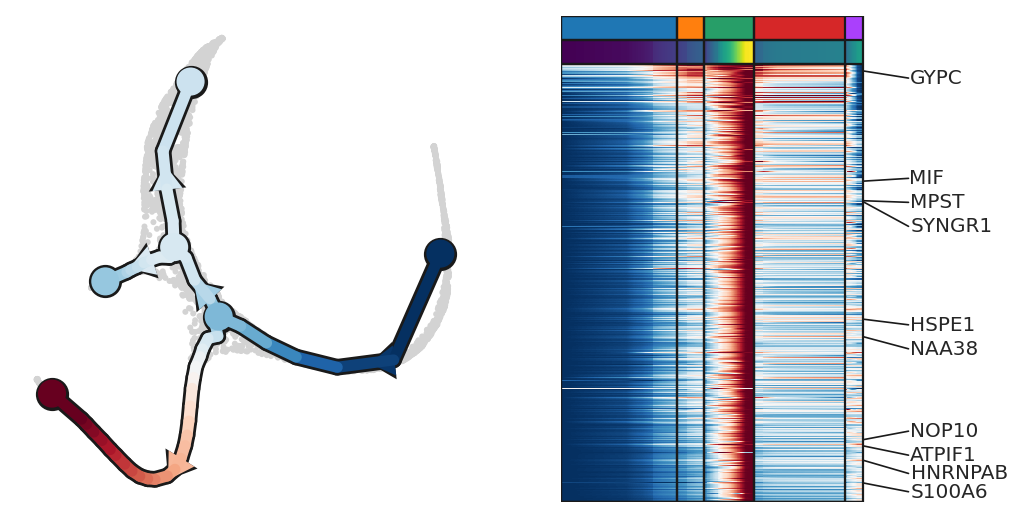

In [23]:
for c in pd.Series(adata.var["fit_clusters"]).unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.fit_clusters==c],
                  basis="draw_graph_fa",annot="seg",arrows=True,arrow_offset=1)

In [27]:
adata_empty=sc.AnnData(np.zeros((adata.shape[0],1)),obsm=adata.obsm,uns=adata.uns)

In [33]:
adata.uns["epg"]["Edges"]=adata.uns["epg"]["Edges"][0]

In [34]:
adata_empty.write_h5ad("empty_tree.h5ad")